TALLER 4. PREPARACION DE DATOS PARA PROYECTO PREDICCION DE PRECIO DE CIERRE DE BTC VS USDT

Estudiante: Albin Rivera Paja

CARGA DE LIBRERIAS

In [1]:
#Carga de librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split


#Estacionalidad
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


CARGA DE BASE DE DATOS

In [2]:
#Carga de base de datos
path="Data/DataLimpiaBTCUSDT_4h_Binance.csv"
df = pd.read_csv(path)
df

,timestamp,close,volume,fecha
0,1.502957e+12,4427.30,63.619882,2017-08-17 08:00:00
1,1.502971e+12,4352.34,174.562001,2017-08-17 12:00:00
2,1.502986e+12,4325.23,225.109716,2017-08-17 16:00:00
3,1.503000e+12,4285.08,249.769913,2017-08-17 20:00:00
4,1.503014e+12,4292.39,276.193043,2017-08-18 00:00:00
...,...,...,...,...
15325,1.723867e+12,59248.00,1106.844530,2024-08-17 04:00:00
15326,1.723882e+12,59137.12,1327.011360,2024-08-17 08:00:00
15327,1.723896e+12,59388.11,1490.864120,2024-08-17 12:00:00
15328,1.723910e+12,59473.19,1157.010550,2024-08-17 16:00:00


DESCOMPOSICION DE LA SERIE DE TIEMPO DE CLOSE

Ademas del analisis exploratorio realizado en el Taller Analisis univariado, para el caso de la variable "close" que para este proyecto es la variable objetivo, y para asegurarse de llevar a cabo la preparación de los datos que garantice un mejor rendimiento de los modelos a implementar; se lleva a cabo la identificación de su comportamiento en cuanto a tendencia, estacionalidad y comportamiento aleatorio, y se evalua la autocorrelacion de dicha variable a partir de Autocorrelación ACF y Autocorrelación Parcial PACF:

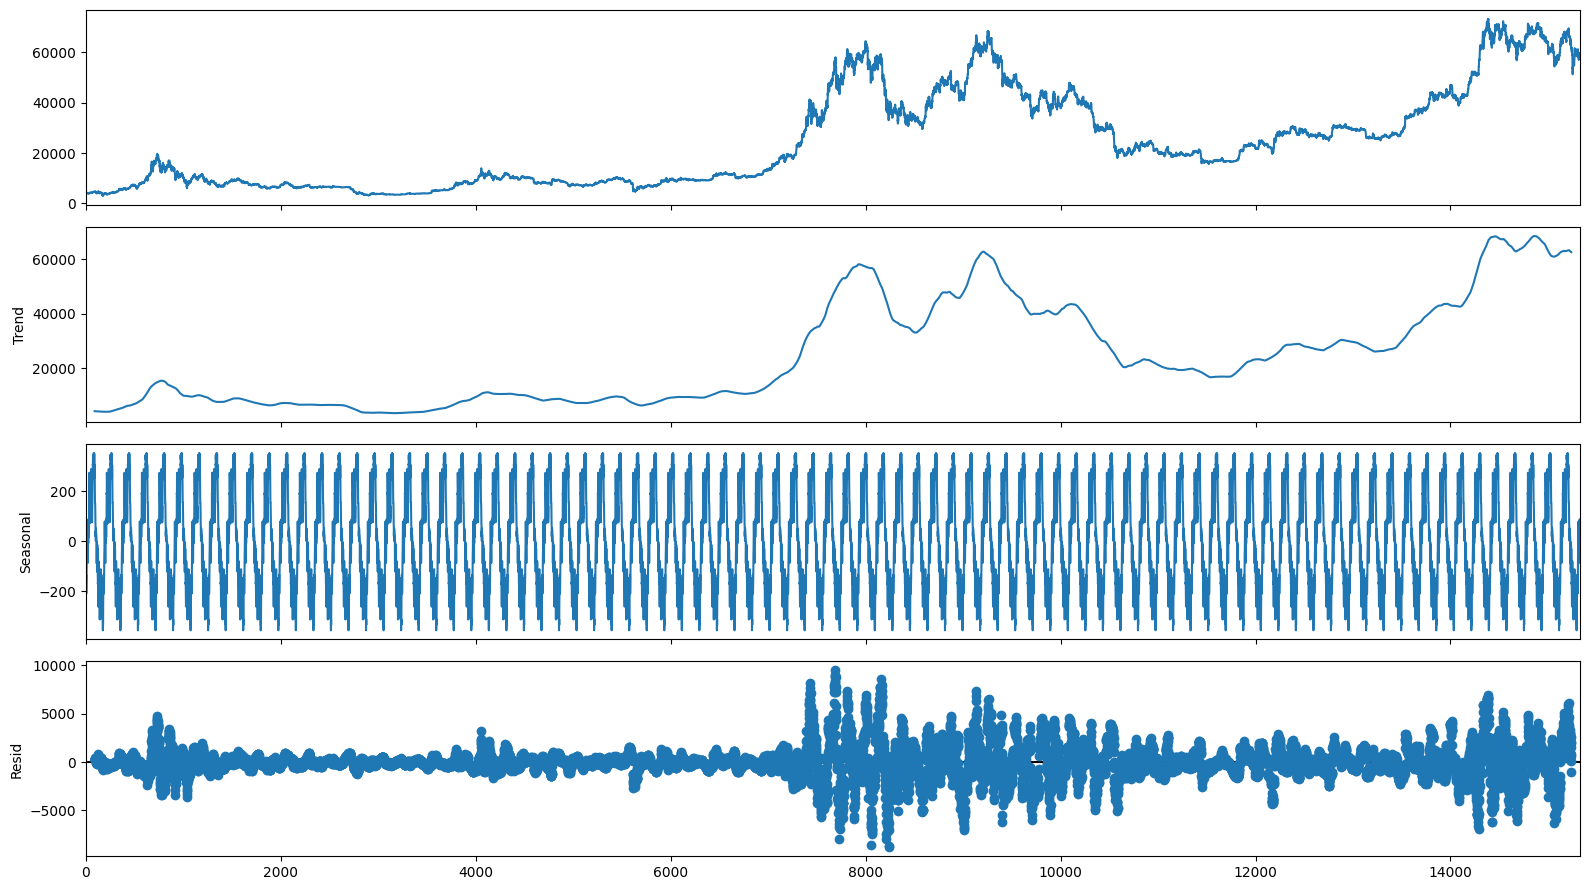

In [3]:
# Conversión de timestamp a formato datetime
df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms')

#Grafica de descomposicion del comportamiento de la variable "close"
periodo = 180
td_componentes = seasonal_decompose(df[["close"]], model="additive", period=periodo)
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

La grafica anterior muestra la descomposición de la serie temporal de close:

La primera grafica representa representa la serie temporal original de close a lo largo del tiempo, reflejando el comportamiento de esta en cada intervalo de tiempo; donde se puede observar varios ciclos de aumento y disminución en el precio de cierre o close del BTC. Hay períodos de crecimiento significativo seguidos de caídas abruptas.

La segunda grafica representa la tendencia, es decir la direccion subyacente a largo plazo del precio de cierre de BTC, donde filtra las fluctuaciones a corto plazo para identificar la tendencia general. De acuerdo a lo anterior la tendencia muestra un crecimiento inicial en los precios, seguido de una estabilización y un gran aumento posterior, después del aumento significativo, la tendencia comienza a disminuir ligeramente, lo que podría indicar una corrección en el mercado o un ajuste después de una fase fuerte del mercado.

Este componente es crucial para entender los ciclos de mercado a largo plazo y para identificar cuándo el mercado está en una fase de expansión (alcista) o contracción (bajista).

La tercer grafica representa la estacionalidad, la cual captura los patrones cíclicos y repetitivos en la serie de tiempo. En este caso la estacionalidad muestra un patrón regular y predecible que se repite a lo largo del tiempo, debido a que la serie esta a intervalos de 4 horas, estos ciclos podrían representar comportamientos intra-diarios o semanales que afectan el precio de cierre del BTC. Estos picos y valles regulares pueden indicar que estan asociados con horarios especificos del día en los que hay mayor actividad transaccional, influenciados por factores como la apertura y cierre de mercados o por eventos recurrentes que influyen en este mercado.

Finalmente la cuarta grafica muestra las irregularidades en los datos que no son capturados por la tendencia ni por la estacionalidad, en otras palabras estos pueden ser el ruido blanco, que no muestran patrones. Para el caso del comportamiento de la serie de tiempo de close se evidencia variabilidad con periodos de alta y baja volatilidad, los cuales no pueden ser explicados por patrones de tendencia y estacionalidad, y se puede diferir respecto a este comportamiento que factores como noticias economicas, eventos geopoliticos o comportamientos en otros mercados financieros, puede afectar el comportamiento del precio de cierre de BTC. Esta grafica proporciona información sobre la volatilidad no anticipada y presenta información para adecuar el modelo predictivo que capture este tipo de impactos externos.


AUTOCORRELACION ACF Y AUTOCORRELACION PARCIAL PACF

<Figure size 640x480 with 0 Axes>

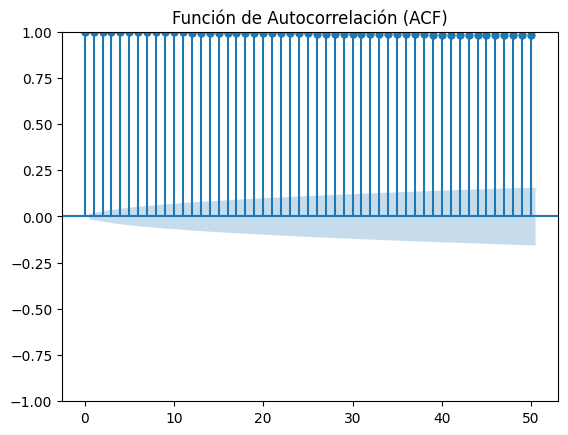

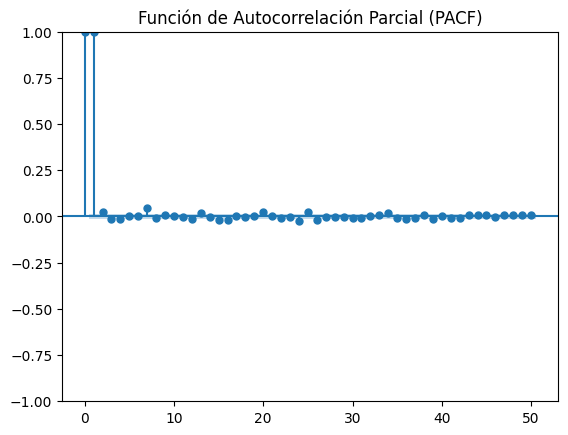

In [4]:

plt.tight_layout()
plt.show()

# 2. Gráficos de Autocorrelación y Autocorrelación Parcial
# Esto ayuda a visualizar si hay autocorrelación en retardos específicos (indicando estacionalidad)
plot_acf(df['close'], lags=50)
plt.title('Función de Autocorrelación (ACF)')
plt.show()

plot_pacf(df['close'], lags=50)
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

A continuación se presenta la interpretación de Autocorrelación para la serie de tiempo de close:

Función de Autocorrelación (ACF)

Esta gráfica muestra cómo cada valor en la serie temporal está correlacionado con sus valores anteriores en diferentes retardos. Cada barra vertical representa la autocorrelación en un retardo específico. Para este caso se puede evidencia que inicialmente existe una alta autocorrelación, ya que las barras de autocorrelación son muy altas y están por encima de la línea de significancia para casi todos los lags hasta al menos el lag 50, que en definitiva indica una fuerte autocorrelación persistente en los datos. Por otro lado como se evidencia que las barras no caen rapidamente hacia cero, esto puede indicar que la serie temporal es muy dependiente de sus valores pasados, mostrando una tendencia a largo plazo de los datos (capturando periodos prolongados de alta y baja volatilidad). El alto nivel de autocorrelación puede indicar que los cambios en el precio de cierre o close de BTC, esta influenciado por su comportamiento a lo largo de periodos extensos debido a factores macroeconomicos, noticias, regulaciones o comportamiento de los inversionistas en este mercado.


Función de Autocorrelación Parcial (PACF)

Esta gráfica muestra la correlación entre los valores de la serie temporal con sus retardos, pero eliminando la influencia de los valores intermedios. En otras palabras, muestra la correlación directa en cada lag una vez que se ha ajustado la influencia de los lags anteriores. De acuerdo a lo anterior en este caso para close el Lag 1 es significativo o en otras palabras la primera barra es muy alta, indicando una fuerte correlacion entre entre un valor y el valor inmediatamente anterior, reflejando que los close actuales estan fuertemente influenciados por los close del periodo anterior (4 horas antes). Ahora, tambien se puede identificar una disminución rápida después del primer lag y despues de esta, las correlaciones en PACF caen a cero y permanecen en ese nivel para los siguientes lags, lo que indica que, una vez que se tiene en cuenta el valor inmediatamente anterior, los otros lags no agregan mucha información adicional sobre la dependencia temporal. Dando un punto de partida de que se podria aplicar inicialmente un modelo AR para modelar dicha serie ya que sólo el primer valor de retardo tiene una relación significativa.

Ya con la información del comportamiento de la serie de tiempo de close, tanto de si existen patrones como de tendencia y estacionalidad y adicional el grado de autocorrelación entre la misma, a continuación se lleva a cabo la siguiente preparacion de los datos, teniendo en cuenta en dicho tratamiento, que las transformaciones que se hagan al dataframe no vayan a afectar negativamente este comportamiento inicial, cuando se corran en el modelo a implementar. La preparación de datos que se quiere llevar a cabo es la siguiente: 

* Feature engineering: Para esta se va a crear variables nuevas a partir de las ya existentes, que se consideran importantes para continuar entendiendo los datos.
* Transformación de datos: de acuerdo a la naturaleza de los datos y la proyección de modelos que se espera implementar, se busca que dicha transformación no afecte la tendencia, estacionalidad y fuerte autocorrelación que tiene el dataframe original.
* Selección de las features: que aporten significativamente al rendimiento de los modelos proyectados.

FEATURE ENGINEERING

Con el fin de aprovechar este paso de preparación de datos para capturar patrones y tendencias en los datos históricos de close o precio de cierre de BTC, que aporten información util para la construcción de o los modelos predictivos o para realizar el analisis del mercado. Se plantea crear las siguientes features:

MEDIA MÓVIL

La media móvil es una herramienta de análisis técnico que suaviza las fluctuaciones de precio, facilitando la identificación de tendencias.

Se crea tanto la media movil de 3 periodos (moving_average_3), como la media movil de 7 periodos (moving_average_7), para este caso que cada periodo es de 4 horas, La media movil de 3 periodos utiliza los precios de cierre de las últimas 12 horas (3 períodos de 4 horas) para calcular su valor. Y para el caso de la media movil de 7 periodos utiliza los precios de cierre de los últimos 28 horas (7 períodos de 4 horas) para su cálculo. Esta ultima presenta un panorama mas a largo plazo de la tendencia del precio comparado con la media móvil de 3 períodos:

In [5]:
# Media Móvil
df['moving_average_3'] = df['close'].rolling(window=3).mean()
df['moving_average_7'] = df['close'].rolling(window=7).mean()

VOLATILIDAD

Esta feature mide la volatilidad del precio de BTC en un periodo determinado. En otras palabras la volatilidad generalmente se calcula como la desviación estándar de los retornos de precios durante un período de tiempo específico. Para este caso se crearon las features volatility_3 la cual mide la volatilidad del precio de BTC en los últimos 3 períodos de 4 horas, es decir cuanto varia el precio en las ultimas 12 horas. De igual forma se creo la feature volatility_7 la cual mide la volatilidad del precio de BTC en los últimos 7 períodos de 4 horas, es decir cuanto varia el precio en las ultimas 12 horas. Esta ultima Proporciona una perspectiva de la variabilidad del precio en un rango de tiempo más amplio, comparado con volatility_3: 

In [6]:
# Volatilidad
df['volatility_3'] = df['close'].rolling(window=3).std()
df['volatility_7'] = df['close'].rolling(window=7).std()

RATIO DE CAMBIO

Finalmente la feature price_change, la cual indica el cambio porcentual en el precio de cierre entre períodos consecutivos de 4 horas. En otras palabras es una medida de la tasa de cambio del precio, que ayuda a evaluar si el precio está subiendo o bajando y en qué magnitud: 

In [7]:
# Ratio de Cambio
df['price_change'] = df['close'].pct_change()


Ya creadas las features que se consideran relevantes para el proyecto, se visualiza a continuación en el dataframe:

In [8]:
#Dataframe con las nuevas features
df

,timestamp,close,volume,fecha,moving_average_3,moving_average_7,volatility_3,volatility_7,price_change
0,1.502957e+12,4427.30,63.619882,2017-08-17 08:00:00,NaN,NaN,NaN,NaN,NaN
1,1.502971e+12,4352.34,174.562001,2017-08-17 12:00:00,NaN,NaN,NaN,NaN,-0.016931
2,1.502986e+12,4325.23,225.109716,2017-08-17 16:00:00,4368.290000,NaN,52.871288,NaN,-0.006229
3,1.503000e+12,4285.08,249.769913,2017-08-17 20:00:00,4320.883333,NaN,33.840021,NaN,-0.009283
4,1.503014e+12,4292.39,276.193043,2017-08-18 00:00:00,4300.900000,NaN,21.385058,NaN,0.001706
...,...,...,...,...,...,...,...,...,...
15325,1.723867e+12,59248.00,1106.844530,2024-08-17 04:00:00,59093.656667,58841.772857,194.930120,564.486594,0.001515
15326,1.723882e+12,59137.12,1327.011360,2024-08-17 08:00:00,59181.163333,58938.934286,58.849347,545.429552,-0.001871
15327,1.723896e+12,59388.11,1490.864120,2024-08-17 12:00:00,59257.743333,59080.092857,125.778354,509.376881,0.004244
15328,1.723910e+12,59473.19,1157.010550,2024-08-17 16:00:00,59332.806667,59280.397143,174.727231,262.143169,0.001433


TRANSFORMACION DE DATOS

En función del analisis estadistica y grafica de la serie de tiempo, realizado anteriormente, se procede a explorar la transformación bajo los siguientes metodos: 

* Min-Max Scaling: Esta es una técnica de normalización de datos que ajusta los valores de una variable para que queden en un rango específico, normalmente  entre 0 y 1. Este método sirve para escalar características a un rango uniforme, lo que puede mejorar la eficiencia y precisión de los modelos sensibles a las escalas de las variables.

* Estandarización (Z-Score): es una técnica de normalización de datos que transforma los valores de una variable para que tengan una media de 0 y una desviación estándar de 1.  Este método sirve para centrar y escalar los datos, lo que facilita la comparación de diferentes características en los modelos, principalmente cuando dichas caracteristicas estan en diferentes unidades o escalas.

* Transformaciones de Potencia (Yeo-Johnson): Debido a que los precios de cierre o close de BTC muestran una distribución sesgada a la derecha, es decir con valores atípicos significativos (ver Taller Analisis Univariado), este tipo de transformación pueden ayudar a estabilizar la varianza, reducir el sesgo y hacer que los datos se parezcan más a una distribución normal, permitiendo mayor rendimiento para algunos modelos que asumen normalidad o una varianza constante.

Antes de realizar la normalización de los datos y para no afectar la data original se procede a crear una copia de esta para llevar a cabo las transformaciones, se asegura que el dataframe original no se altere (ver estadistica descripitva) y adicional se dejan solo las columnas que se consideran requeridas para dicha transformación:

In [9]:
# Crear una copia del DataFrame original
df_original = df.copy()

# Seleccionar solo las columnas numéricas que no sean 'timestamp'
columns_selec = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'timestamp']

# Imprimir los valores mínimos y máximos antes de la normalización
print("Valores antes de la normalización:")
print(df[columns_selec].describe())



Valores antes de la normalización:
              close         volume  moving_average_3  moving_average_7  \
count  15330.000000   15330.000000      15328.000000      15324.000000   
mean   24421.608021   11694.940039      24420.634574      24418.704259   
std    19054.401615   15266.761527      19050.705537      19044.266275   
min     2919.000000       0.000000       3145.666667       3214.185714   
25%     8257.200000    4126.861440       8247.598333       8244.133214   
50%    19051.700000    6973.718980      19051.563333      19069.108571   
75%    38282.377500   12564.660878      38304.620000      38278.458571   
max    73349.240000  284711.694213      73229.576667      73071.012857   

       volatility_3  volatility_7  price_change  
count  15328.000000  15324.000000  15329.000000  
mean     205.034636    316.459774      0.000293  
std      285.622183    381.991513      0.015732  
min        0.196299      3.347684     -0.204962  
25%       37.022840     71.114593     -0.005039 

Se verifica que efectivamente hayan quedado solo las columnas requeridas:

In [10]:
df[columns_selec]

,close,volume,moving_average_3,moving_average_7,volatility_3,volatility_7,price_change
0,4427.30,63.619882,NaN,NaN,NaN,NaN,NaN
1,4352.34,174.562001,NaN,NaN,NaN,NaN,-0.016931
2,4325.23,225.109716,4368.290000,NaN,52.871288,NaN,-0.006229
3,4285.08,249.769913,4320.883333,NaN,33.840021,NaN,-0.009283
4,4292.39,276.193043,4300.900000,NaN,21.385058,NaN,0.001706
...,...,...,...,...,...,...,...
15325,59248.00,1106.844530,59093.656667,58841.772857,194.930120,564.486594,0.001515
15326,59137.12,1327.011360,59181.163333,58938.934286,58.849347,545.429552,-0.001871
15327,59388.11,1490.864120,59257.743333,59080.092857,125.778354,509.376881,0.004244
15328,59473.19,1157.010550,59332.806667,59280.397143,174.727231,262.143169,0.001433


Ya con el dataframe listo para las transformaciones, se procede a aplicar las 3 indicadas anteriormente; y para verificar el impacto de estas en los datos, se lleva a cabo la evaluación de las mismas a partir de los modelos ARIMA y SARIMA (es un modelo que es mas sensible a estacionalidad), donde evaluando las metricas de MSE y RMSE, se identifica cual de estas transformaciones tuvo el mejor rendimiento:

MIN-MAX SCALING

In [11]:
# Crear una instancia del MinMaxScaler
min_max_scaler = MinMaxScaler()

# Aplicar Min-Max Scaling a todas las columnas numéricas
df_normalized = df.copy()
df_normalized[columns_selec] = min_max_scaler.fit_transform(df[columns_selec])

#df[columns_selec] = min_max_scaler.fit_transform(df[columns_selec])

# Imprimir los valores mínimos y máximos después de la normalización
print("\nValores después de la normalización:")
print(df_normalized[columns_selec].describe())



Valores después de la normalización:
              close        volume  moving_average_3  moving_average_7  \
count  15330.000000  15330.000000      15328.000000      15324.000000   
mean       0.305304      0.041076          0.303564          0.303543   
std        0.270543      0.053622          0.271827          0.272619   
min        0.000000      0.000000          0.000000          0.000000   
25%        0.075794      0.014495          0.072797          0.072004   
50%        0.229059      0.024494          0.226955          0.226963   
75%        0.502105      0.044131          0.501669          0.501945   
max        1.000000      1.000000          1.000000          1.000000   

       volatility_3  volatility_7  price_change  
count  15328.000000  15324.000000  15329.000000  
mean       0.061942      0.077261      0.396970  
std        0.086370      0.094257      0.030426  
min        0.000000      0.000000      0.000000  
25%        0.011136      0.016722      0.386658  
50% 

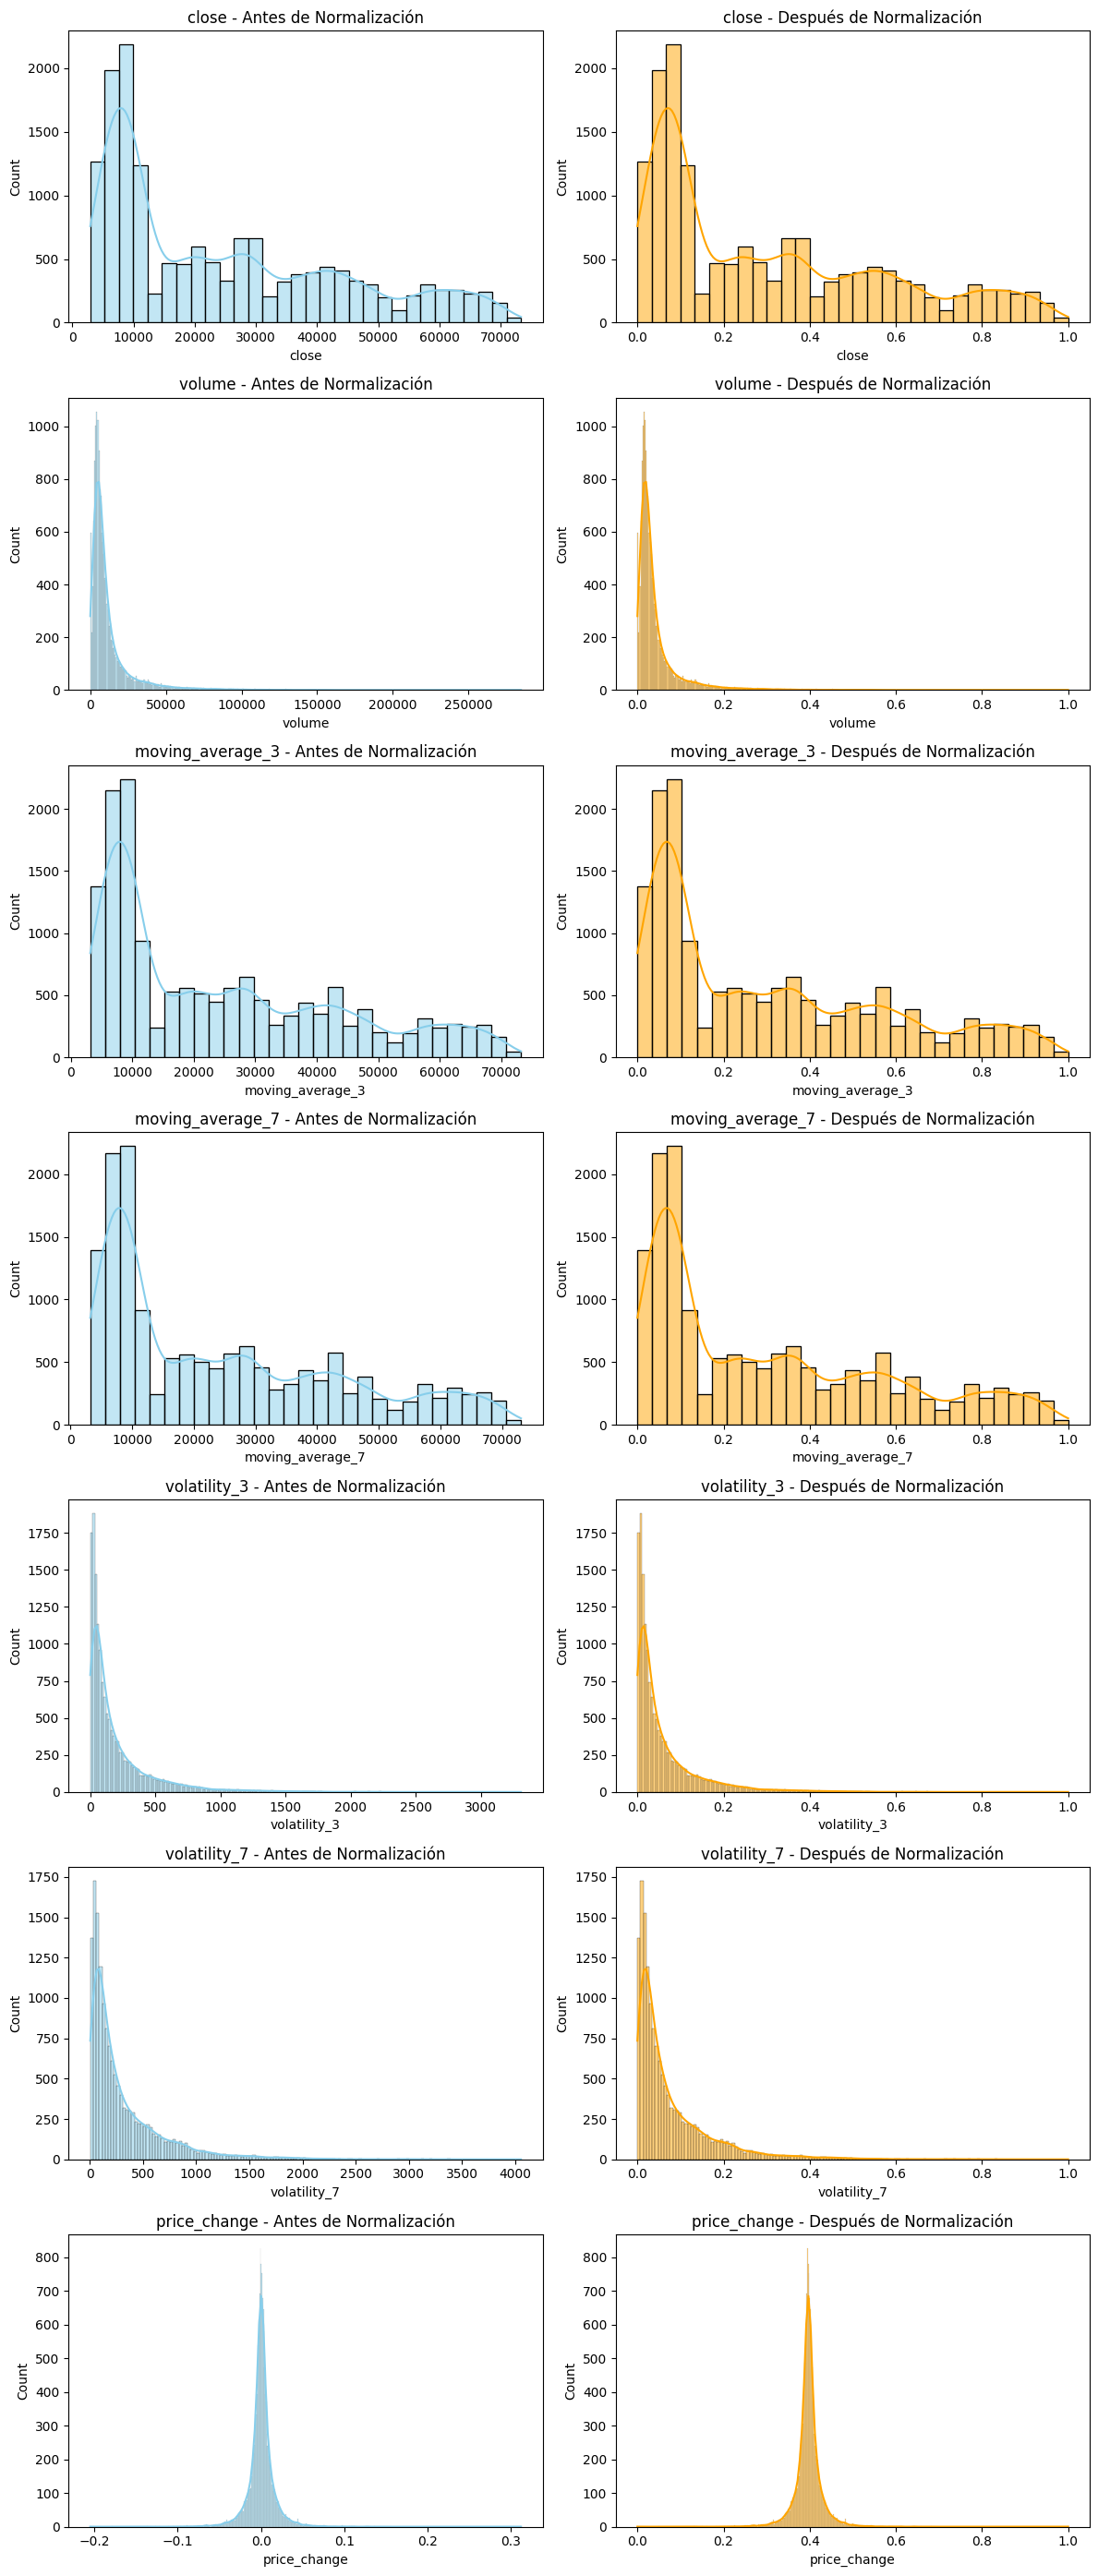

In [12]:
# Visualización de la normalización
fig, axes = plt.subplots(nrows=len(columns_selec), ncols=2, figsize=(12, 4 * len(columns_selec)))

for i, column in enumerate(columns_selec):
    # Gráfico de distribución antes de la normalización usando df_original
    sns.histplot(df_original[column], ax=axes[i, 0], kde=True, color='skyblue')
    axes[i, 0].set_title(f'{column} - Antes de Normalización')
    
    # Gráfico de distribución después de la normalización usando df_normalized
    sns.histplot(df_normalized[column], ax=axes[i, 1], kde=True, color='orange')
    axes[i, 1].set_title(f'{column} - Después de Normalización')

plt.tight_layout()
plt.show()

VERIFICACIÓN DEL RENDIMIENTO DE LA TRANSFORMACIÓN MIN-MAX SCALING CON MODELO ARIMA

Preparación de los datos

In [13]:
# Seleccionar solo la columna de interés (en este caso, el precio de cierre o close)
data = df_normalized['close']

División en conjuntos de entrenamiento y prueba

In [14]:
# Dividir en 80% datos de entrenamiento y 20% datos de prueba
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f'Tamaño del conjunto de entrenamiento: {len(train)}')
print(f'Tamaño del conjunto de prueba: {len(test)}')

Tamaño del conjunto de entrenamiento: 12264
Tamaño del conjunto de prueba: 3066


Entrenamiento del modelo ARIMA

In [15]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Definir el modelo ARIMA (p=5, d=1, q=0 son parámetros comunes; se pueden ajustar según los datos)
model = ARIMA(train, order=(5, 1, 0))

# Entrenar el modelo
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                12264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               45548.337
Date:                Fri, 30 Aug 2024   AIC                         -91084.673
Time:                        16:43:56   BIC                         -91040.187
Sample:                             0   HQIC                        -91069.767
                              - 12264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0478      0.004    -11.192      0.000      -0.056      -0.039
ar.L2          0.0280      0.004      7.208      0.000       0.020       0.036
ar.L3          0.0247      0.004      5.689      0.0

Predicción y evaluación

In [16]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Error Cuadrático Medio (MSE): 0.10794158285443398
Raíz del Error Cuadrático Medio (RMSE): 0.32854464362462826


El error cuadratico medio (MSE) para este caso es de aproximadamente 0.108, lo que se puede considerar relativamente bajo, debido a que los datos aqui se normalizaron entre 0 y 1, se puede decir que el modelo tiene un ajuste considerablemente bueno.

En cuanto al RMSE que indica que tan cerca estan las predicciones del modelo en promedio cerca de los valores reales; se puede decir que para este caso tendiendo uno RMSE aproximadamente 0.329, se puede considerar razonable.

En general tendiendo en cuenta que los datos se normalizaron en un rango de 0 a 1, tanto el MSE como el RMSE estan dentro de este rango, indicando que es coherente el resultado, siendo esto que los errores de predicción son bajos en relacion con la escala de los datos.


VERIFICACIÓN DEL RENDIMIENTO DE LA TRANSFORMACIÓN MIN-MAX SCALING CON MODELO SARIMA

Entrenamiento del modelo SARIMA

In [17]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX 

# Definir el modelo SARIMA
model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 0, 42))

# Entrenar el modelo
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                12264
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 42)   Log Likelihood               42900.076
Date:                            Fri, 30 Aug 2024   AIC                         -85786.153
Time:                                    16:49:59   BIC                         -85734.276
Sample:                                         0   HQIC                        -85768.766
                                          - 12264                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0499      0.005    -11.085      0.000      -0.059      -0.041
ar.L2          0.0363      0.004   

Predicción y evaluación

In [18]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Error Cuadrático Medio (MSE): 1.5292415730867124
Raíz del Error Cuadrático Medio (RMSE): 1.2366250737740652


En el caso de los resultados que arrojo el modelo SARIMA, se evidencia un incremento significativo tanto en el MSE como en el RMSE, adicional a esto, los datos no se encuentran dentro del rango de 0 a 1 bajo el cual se llevo a cabo la normalizacion de los datos con Min-Max, por ende se puede decir que el modelo SARIMA está teniendo dificultades para ajustar completamente las fluctuaciones en los precios de cierre de BTC.

Ahora, comparando los resultados de ARIMA con los de SARIMA, se podria decir que al parecer la estacionalidad puede no ser significativa en los datos del precio de cierre de BTC, o que los parámetros estacionales de SARIMA no están óptimamente ajustados, sin embargo como el objetivo de este taller no es evaluar modelos, se procede a dejar el resultado actual y queda como mejora para el taller final, donde se procedera a evaluar los modelos a implementar y realizar sus respectivos ajustes de parametros.

ESTANDARIZACIÓN (Z-SCORE)

In [19]:
# Crear una instancia del StandardScaler
scaler = StandardScaler()

# Aplicar Z-Score Scaling a las columnas numéricas seleccionadas
df_standar = df.copy()
df_standar[columns_selec] = scaler.fit_transform(df[columns_selec])

# Imprimir los valores mínimos y máximos después de la estandarización
print("\nValores después de la estandarización:")
print(df_standar[columns_selec].describe())



Valores después de la estandarización:
              close        volume  moving_average_3  moving_average_7  \
count  1.533000e+04  1.533000e+04      1.532800e+04      15324.000000   
mean  -5.932777e-17  1.483194e-17      5.933551e-17          0.000000   
std    1.000033e+00  1.000033e+00      1.000033e+00          1.000033   
min   -1.128522e+00 -7.660643e-01     -1.116791e+00         -1.113470   
25%   -8.483570e-01 -4.957388e-01     -8.489745e-01         -0.849342   
50%   -2.818290e-01 -3.092585e-01     -2.818398e-01         -0.280912   
75%    7.274551e-01  5.697012e-02      7.288149e-01          0.727789   
max    2.567870e+00  1.788367e+01      2.562138e+00          2.554779   

       volatility_3  volatility_7  price_change  
count  15328.000000  1.532400e+04  1.532900e+04  
mean       0.000000  5.935100e-17 -1.854114e-18  
std        1.000033  1.000033e+00  1.000033e+00  
min       -0.717189 -8.197101e-01 -1.304750e+01  
25%       -0.588250 -6.423001e-01 -3.389289e-01  
50

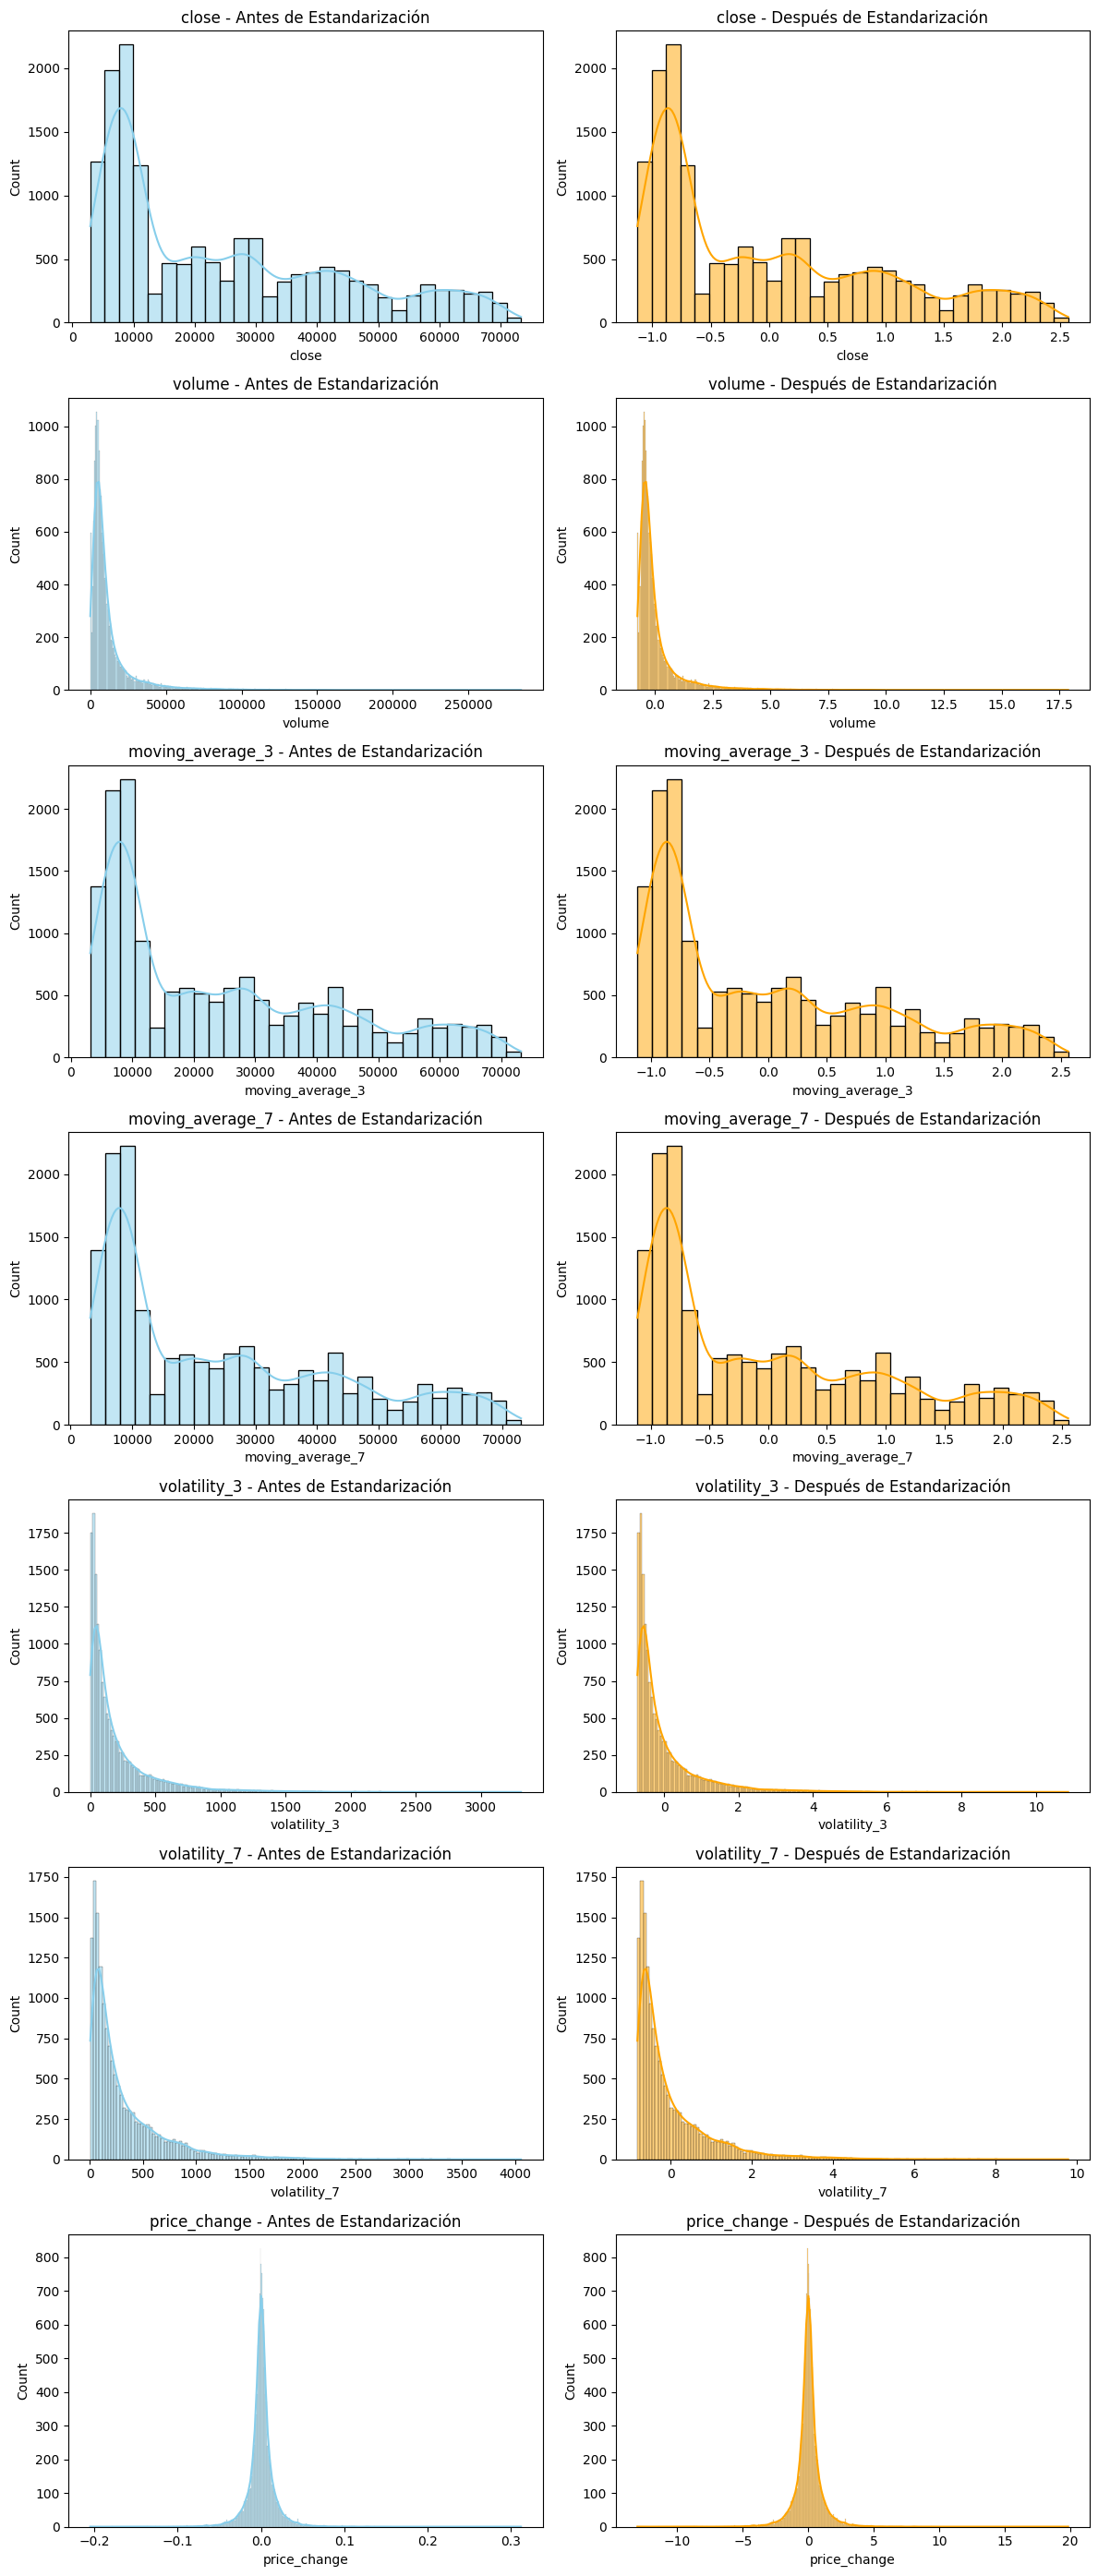

In [20]:
# Visualización de la estandarización
fig, axes = plt.subplots(nrows=len(columns_selec), ncols=2, figsize=(12, 4 * len(columns_selec)))

for i, column in enumerate(columns_selec):
    # Gráfico de distribución antes de la estandarización
    sns.histplot(df_original[column], ax=axes[i, 0], kde=True, color='skyblue')
    axes[i, 0].set_title(f'{column} - Antes de Estandarización')
    
    # Gráfico de distribución después de la estandarización
    sns.histplot(df_standar[column], ax=axes[i, 1], kde=True, color='orange')
    axes[i, 1].set_title(f'{column} - Después de Estandarización')

plt.tight_layout()
plt.show()

VERIFICACIÓN DEL RENDIMIENTO DE LA TRANSFORMACIÓN STANDARDIZATION (Z-SCORE) CON MODELO ARIMA

Preparación de los datos

In [21]:
# Seleccionar solo la columna de interés (en este caso, el precio de cierre o close)
data = df_standar['close']

División en conjuntos de entrenamiento y prueba

In [22]:
# Dividir en 80% datos de entrenamiento y 20% datos de prueba
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f'Tamaño del conjunto de entrenamiento: {len(train)}')
print(f'Tamaño del conjunto de prueba: {len(test)}')

Tamaño del conjunto de entrenamiento: 12264
Tamaño del conjunto de prueba: 3066


Entrenamiento del modelo ARIMA

In [23]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Definir el modelo ARIMA (p=5, d=1, q=0 son parámetros comunes; se pueden ajustar según los datos)
model = ARIMA(train, order=(5, 1, 0))

# Entrenar el modelo
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                12264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               29516.215
Date:                Fri, 30 Aug 2024   AIC                         -59020.430
Time:                        16:50:35   BIC                         -58975.944
Sample:                             0   HQIC                        -59005.523
                              - 12264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0478      0.004    -11.197      0.000      -0.056      -0.039
ar.L2          0.0280      0.004      7.211      0.000       0.020       0.036
ar.L3          0.0247      0.004      5.691      0.0

Predicción y evaluación

In [24]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Error Cuadrático Medio (MSE): 1.4748397018182144
Raíz del Error Cuadrático Medio (RMSE): 1.2144297846389533


Comparando con los resultados de MSE y RMSE obtenidos con la transformación anterior, estos valores son considerablemente altos, indicando que la predicciones del modelo ARIMA con los datos sujetos a estandarización o Z score, estan en promedio mas lejos de los valores reales, en comparación con los datos transformados con Normalización Min-Max

Un RMSE de aproximadamente 1.214 indica que en promedio, las predicciones del modelo se desviaron del valor real por un margen de más de una desviación estándar, tendiendo en cuenta el rango en el que estan los datos. 

El modelo ARIMA puede ser sensible a la escala y la transformación de los datos de entrada. Deduciendo que estan estandarización afecta negativamente el modelo porque ajusta los datos a una distribución centrada alrededor de 0. 

TRANSFORMACIONES DE POTENCIA (YEO-JOHNSON)

Yeo-Johnson es una transformación que puede trabajar con datos tanto positivos como negativos y es robusta frente a valores atipicos, permitiendo asi estabilizar series de tiempo con fluctuaciones significativas. A continuación se lleva a cabo el proceso de transformación:

In [25]:
from sklearn.preprocessing import PowerTransformer

# Crear una instancia del PowerTransformer con método 'yeo-johnson'
power_transformer = PowerTransformer(method='yeo-johnson')

# Aplicar Yeo-Johnson a las columnas numéricas seleccionadas y crear un nuevo DataFrame
df_yeo_johnson = df.copy()
df_yeo_johnson[columns_selec] = power_transformer.fit_transform(df[columns_selec])

# Imprimir los valores mínimos y máximos después de la transformación
print("\nValores después de la transformación Yeo-Johnson:")
print(df_yeo_johnson[columns_selec].describe())


Valores después de la transformación Yeo-Johnson:
              close        volume  moving_average_3  moving_average_7  \
count  1.533000e+04  1.533000e+04      1.532800e+04      1.532400e+04   
mean  -3.559666e-16  9.789082e-16      5.933551e-16     -7.122120e-16   
std    1.000033e+00  1.000033e+00      1.000033e+00      1.000033e+00   
min   -1.983886e+00 -4.321220e+00     -1.905589e+00     -1.883548e+00   
25%   -8.610506e-01 -5.407511e-01     -8.625395e-01     -8.633495e-01   
50%    8.759136e-02 -7.549789e-02      8.754742e-02      8.855831e-02   
75%    9.120712e-01  4.984343e-01      9.128527e-01      9.121874e-01   
max    1.708124e+00  4.713522e+00      1.706268e+00      1.703903e+00   

       volatility_3  volatility_7  price_change  
count  1.532800e+04  1.532400e+04  1.532900e+04  
mean  -2.670098e-16  7.715630e-16  7.416455e-18  
std    1.000033e+00  1.000033e+00  1.000033e+00  
min   -3.116140e+00 -2.851002e+00 -1.401516e+01  
25%   -7.250713e-01 -7.362786e-01 -3.3420

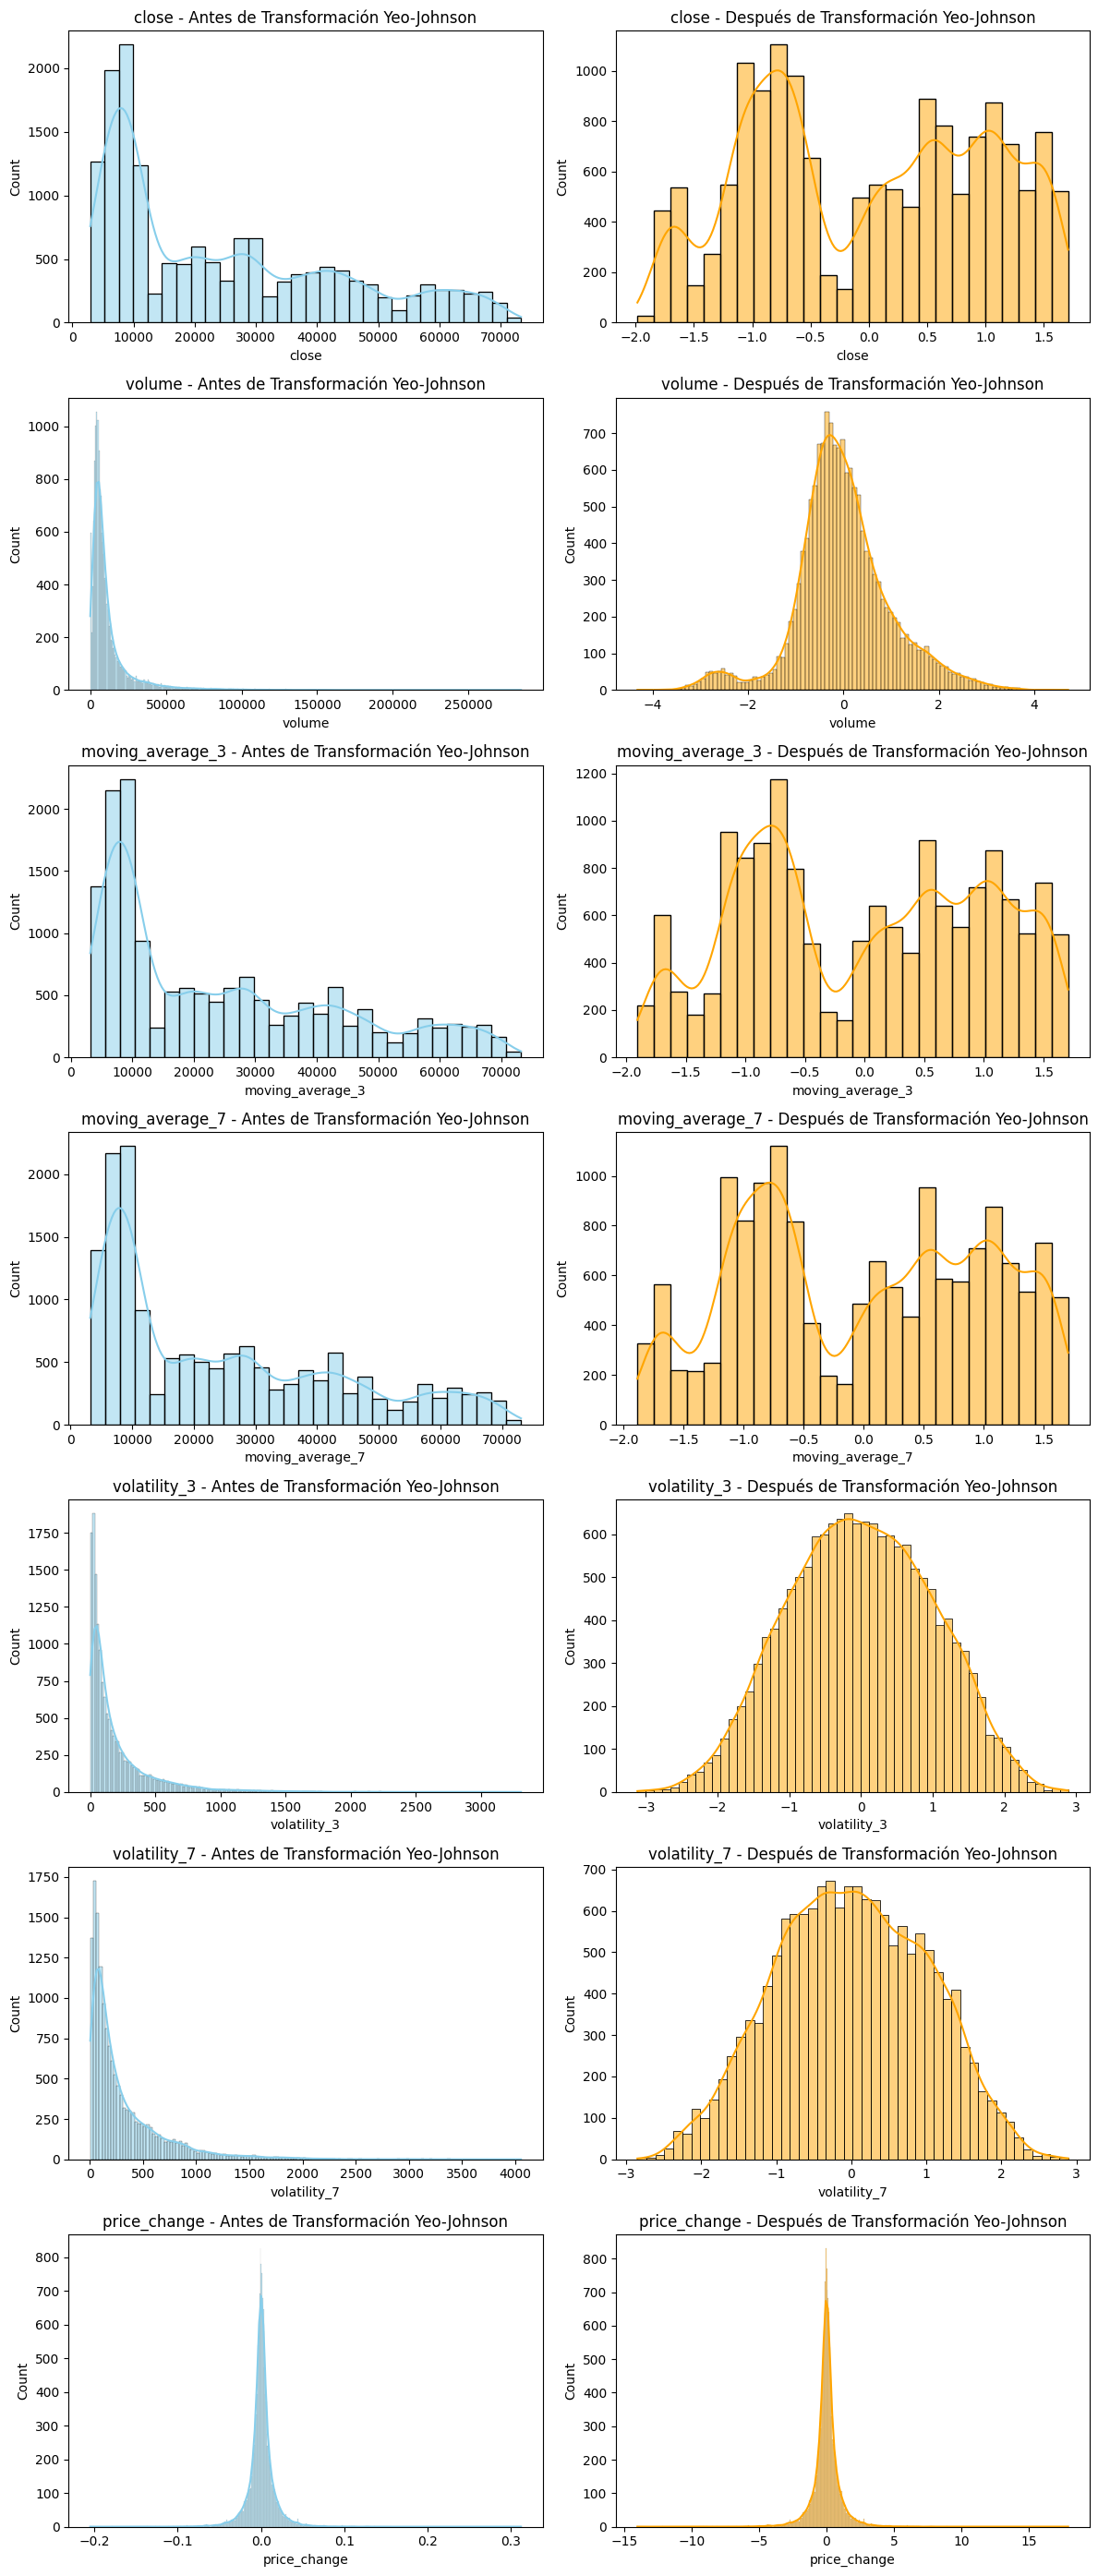

In [26]:
# Visualización de la transformación
fig, axes = plt.subplots(nrows=len(columns_selec), ncols=2, figsize=(12, 4 * len(columns_selec)))

for i, column in enumerate(columns_selec):
    # Gráfico de distribución antes de la transformación usando df_original
    sns.histplot(df_original[column], ax=axes[i, 0], kde=True, color='skyblue')
    axes[i, 0].set_title(f'{column} - Antes de Transformación Yeo-Johnson')
    
    # Gráfico de distribución después de la transformación usando df_yeo_johnson
    sns.histplot(df_yeo_johnson[column], ax=axes[i, 1], kde=True, color='orange')
    axes[i, 1].set_title(f'{column} - Después de Transformación Yeo-Johnson')

plt.tight_layout()
plt.show()

VERIFICACIÓN DEL RENDIMIENTO DE LA TRANSFORMACIÓN YEO-JOHNSON CON MODELO ARIMA

Preparación de los datos

In [27]:
# Seleccionar solo la columna de interés (en este caso, el precio de cierre o close)
data = df_yeo_johnson['close']

División en conjuntos de entrenamiento y prueba

In [28]:
# Dividir en 80% datos de entrenamiento y 20% datos de prueba
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f'Tamaño del conjunto de entrenamiento: {len(train)}')
print(f'Tamaño del conjunto de prueba: {len(test)}')

Tamaño del conjunto de entrenamiento: 12264
Tamaño del conjunto de prueba: 3066


Entrenamiento del modelo ARIMA

In [29]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Definir el modelo ARIMA (p=5, d=1, q=0 son parámetros comunes; se pueden ajustar según los datos)
model = ARIMA(train, order=(5, 1, 0))

# Entrenar el modelo
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                12264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               31051.009
Date:                Fri, 30 Aug 2024   AIC                         -62090.017
Time:                        16:50:50   BIC                         -62045.531
Sample:                             0   HQIC                        -62075.111
                              - 12264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0535      0.005     -9.812      0.000      -0.064      -0.043
ar.L2          0.0003      0.005      0.058      0.954      -0.010       0.011
ar.L3          0.0422      0.004      9.618      0.0

Predicción y evaluación

In [30]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Error Cuadrático Medio (MSE): 0.43334408970975774
Raíz del Error Cuadrático Medio (RMSE): 0.6582887586080729


VERIFICACIÓN DEL RENDIMIENTO DE LA TRANSFORMACIÓN YEO-JOHNSON CON MODELO SARIMA

In [31]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX 

# Definir el modelo SARIMA
model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 0, 42))

# Entrenar el modelo
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                12264
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 42)   Log Likelihood               28461.882
Date:                            Fri, 30 Aug 2024   AIC                         -56909.765
Time:                                    16:55:43   BIC                         -56857.888
Sample:                                         0   HQIC                        -56892.379
                                          - 12264                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0466      0.006     -7.608      0.000      -0.059      -0.035
ar.L2          0.0005      0.006   

In [32]:
import warnings

# Para ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Error Cuadrático Medio (MSE): 21.871685499796484
Raíz del Error Cuadrático Medio (RMSE): 4.676717385067916


Comparando los resultados de Yeo-johnson con los de Min-Max Scaling, los valores de MSE y RMSE son mayores con Yeo-Johnson tanto con el modelo ARIMA como con el modelo SARIMA, lo que podria decir que las predicciones del modelo ARIMA por ejemplo son menos precisas después de aplicar la transformación Yeo-Johnson. Indicando que al menos en este caso, Min-Max Scaling es una técnica de normalización más adecuada para este conjunto de datos y este modelo específico.

Ahora, comparando los resultados de Yeo-johnson con los resultados de la Estandarización Z-Score, el primero mostro mejores resultados, sin embargo sigue siendo la mejor transformación la normalización Min-Max. Lo anterior puede ser porque Yeo-Johnson pudo no haber mantenido los patrones temporales en los datos tan eficientemente como Min-Max Scaling. Dado que por ejemplo ARIMA es sensible a los patrones de autocorrelación, la alteracion relevante de estos patrones podrian afectar el rendimiento del modelo.

Teniendo en cuenta entonces, que la transformación normalizacion Min-Max fue la que mejores resultados obtuvo, se toma como dataframe para el paso de Feature Selection, el dataframe con dicha transformación.


FEATURE SELECTION

De acuerdo a literatura existen varios tipos de feature selection, entre estos y los que se aplicaran en este proyecto son: 

* Correlación de pearson
* Selección de características basada en árboles (Importancia de características)
* Recursive Feature Elimination (RFE)

Para llevar a cabo este paso, primero se adecua el dataframe a continuación:

In [33]:
# Crear un DataFrame de características y la variable objetivo
features = df_normalized.drop(columns=['close', 'fecha', 'timestamp'])
target = df_normalized['close']

CORRELACION DE PEARSON

Esta técnica calcula la correlación de Pearson entre cada característica y la variable objetivo que para este caso es close; para identificar características que están altamente correlacionadas con dicha variable:

Correlación de Pearson con la variable objetivo:
close               1.000000
moving_average_3    0.999860
moving_average_7    0.999527
fecha               0.734236
timestamp           0.734236
volatility_7        0.615223
volatility_3        0.533752
price_change        0.005583
volume             -0.016385
Name: close, dtype: float64


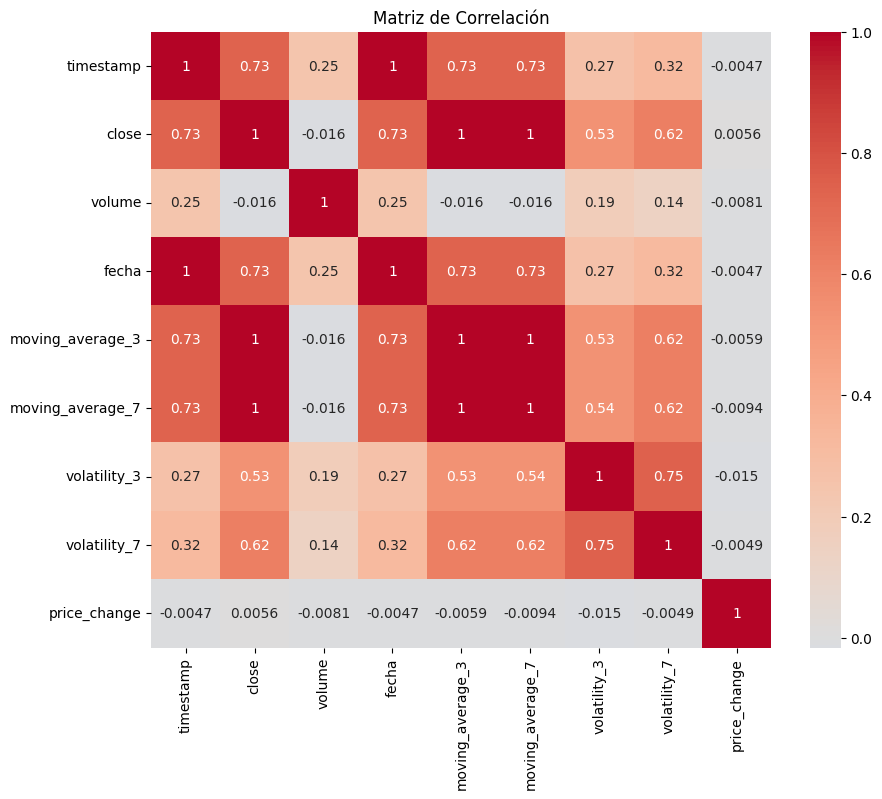

In [34]:
# Calcular la correlación entre cada característica y la variable objetivo
correlation_matrix = df_normalized.corr()
correlation_target = correlation_matrix['close'].sort_values(ascending=False)

print("Correlación de Pearson con la variable objetivo:")
print(correlation_target)

# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

De acuerdo a la matriz de correlación se puede identificar una alta correlación entre la variable objetivo close con moving_average_3, y moving_average_7m indicando que las medias móviles de 3 y 7 periodos están directamente relacionadas con los precios de cierre, sin embargo como estas variables salieron a partir de close, se puede decir que se estaria redundando y por ende no estarian aportando información para los modelos de predicción a implementar.

También se puede observar que la variable close tiene una correlación moderadacib la volatilidad, indicando que las medidas de volatilidad están relacionadas con los cambios en el precio de cierre.

Finalmente la feature volume tiene una correlación muy baja con close (-0.016), lo que indica que el volumen de transacciones no está fuertemente relacionado con los cambios en el precio de cierre en este conjunto de datos. Traduciendose en que el volumen no es un predictor util para el precio de cierre.

SELECCION DE CARACTERISTICAS BASADA EN ARBOLES

Para esta técnica se puede utilizar por ejemplo un modelo basado en árboles como RandomForestRegressor para evaluar la importancia de cada característica (features). A continuación se presenta el desarrollo de esta técnica:

In [35]:
from sklearn.impute import SimpleImputer

# Imputación de valores faltantes
imputer = SimpleImputer(strategy='mean')  # Crear un imputador que reemplace los NaN por la media de cada columna
features_imputed = imputer.fit_transform(features)  # Aplicar la imputación a las características

# Ajustar un modelo RandomForest para evaluar la importancia de las características
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features_imputed, target)

RandomForestRegressor(random_state=42)


Importancia de las características:
moving_average_3    0.999694
price_change        0.000170
volume              0.000076
volatility_3        0.000041
moving_average_7    0.000010
volatility_7        0.000009
dtype: float64


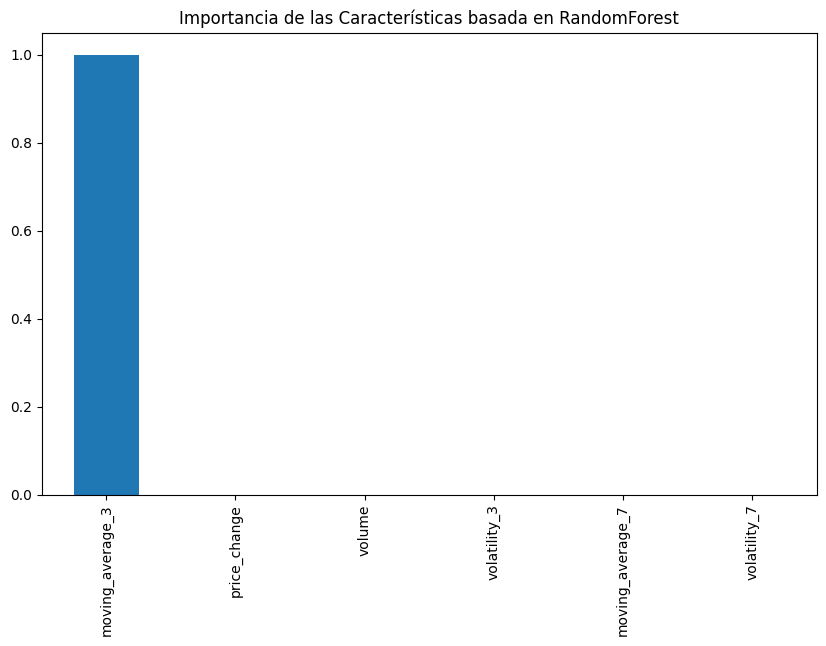

In [36]:
# Obtener la importancia de las características
feature_importances = pd.Series(rf_model.feature_importances_, index=features.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("\nImportancia de las características:")
print(feature_importances)

# Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importancia de las Características basada en RandomForest')
plt.show()

La barra correspondiente a moving_average_3 tiene un valor de importancia de aproximadamente 1.0, indicando que esta característica o feature tiene una importancia significativa en el modelo. En otras palabras moving_average_3 es la característica más predictiva para el valor objetivo en comparación con las demás características.

Las demás características no parecen ser relevantes para predecir el precio de cierre en este caso, es probable que esto quiera decir que dichas caracteristicas no aportan cuando se utilizan de manera aislada en un modelo basado en arboles.

RECURSIVE FEATURE ELIMINATION (RFE)

Esta tecnica selecciona características eliminando recursivamente las menos importantes. Iniciando a entrenar el modelo con todas las características y posteriormente evaluando la importancia de cada característica y eliminando las de menor importancia, este proceso lo repite hasta alcanzar un número deseado de características seleccionadas. A continuación se presenta el desarrollo de la tecnica en mención:

In [37]:
from sklearn.linear_model import LinearRegression

# Convertir los datos imputados de nuevo a un DataFrame para usar nombres de columnas
features_imputed_df = pd.DataFrame(features_imputed, columns=features.columns)

In [38]:
# Utilizar un modelo de regresión lineal para RFE
lr_model = LinearRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5)
rfe.fit(features_imputed_df, target)

# Obtener las características seleccionadas
selected_features = features_imputed_df.columns[rfe.support_]

print("\nCaracterísticas seleccionadas por RFE:")
print(selected_features)

# Filtrar las características seleccionadas para usarlas en un modelo posterior
features_selected = features_imputed_df[selected_features]


Características seleccionadas por RFE:
Index(['moving_average_3', 'moving_average_7', 'volatility_3', 'volatility_7',
       'price_change'],
      dtype='object')


De acuerdo a lo anterior el RFE identifico que la combinación de medias móviles y medidas de volatilidad, junto con el cambio de precio, son las características más relevantes para predecir la variable objetivo. Ya que estas caracteristicas capturan tanto la tendencia como la variabilidad de los precios.

3. CONCLUSIONES


La transformación que mejor rendimiento presento en el dataframe fue la normalizacion Min-Max, arrojando tanto en el modelo ARIMA como en el SARIMA los mejores MSE y RMSE, teniendo en cuenta que los modelos que se estan contemplando para predecir el precio de cierre de BTC, son este tipo de modelos.

Tambien es importante comprender que la seleccion del tipo de transformación de datos, dependera de la pregunta SMART que se quiere responder, de la naturaleza de los datos y de los modelos que se quieren implementar, en ese orden al querer predecir el precio de cierre de BTC, a partir de una base de datos que evidencia alta autocorrelación, ademas de que por el tipo de mercado es importante considerar su alta volatilidad (presencia de autliers), es necesario considerar transformaciones que no afecten significativamente esta naturaleza como fue el caso de la transformacion Normalizacion Min-Max.

La combinación de Correlación de Pearson y RFE permitió obtener una visión más completa sobre la selección de características. Mientras Pearson identifica la colinealidad y posibles redundancias entre las características y la variable objetivo como por ejemplo entre esta y las medias moviles, RFE evalúa la importancia de las características basándose en su capacidad para mejorar el rendimiento del modelo al trabajar en conjunto. 

 Las características derivadas directamente de la variable objetivo, como las medias móviles basadas en close, pueden resultar en redundancia, de acuerdo al análisis de Pearson. Aunque RFE las seleccionó como importantes, esto no siempre significa que agreguen nueva información útil para el modelo. Por lo tanto, es crucial diseñar características que no dependan únicamente de la variable objetivo y explorar la inclusión de datos externos, como indicadores macroeconómicos, que podrían capturar variabilidades no reflejadas en las características internas.

 Sin embargo las características creadas a partir de la variable objetivo, pueden ser relevantes para el análisis del mercado, proporcionando una comprensión valiosa de las tendencias y comportamientos subyacentes.